# Kaggle Playground Series S5E8

Competition link: [https://www.kaggle.com/competitions/playground-series-s5e8](https://www.kaggle.com/competitions/playground-series-s5e8)

This notebook provides a complete workflow for participating in the Playground Series S5E8 competition.

In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

## Load and Explore the Dataset
Load the train and test datasets, display basic info, check for missing values, and visualize key features.

Train shape: (750000, 18)
Test shape: (250000, 17)


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


Missing values in train:


id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

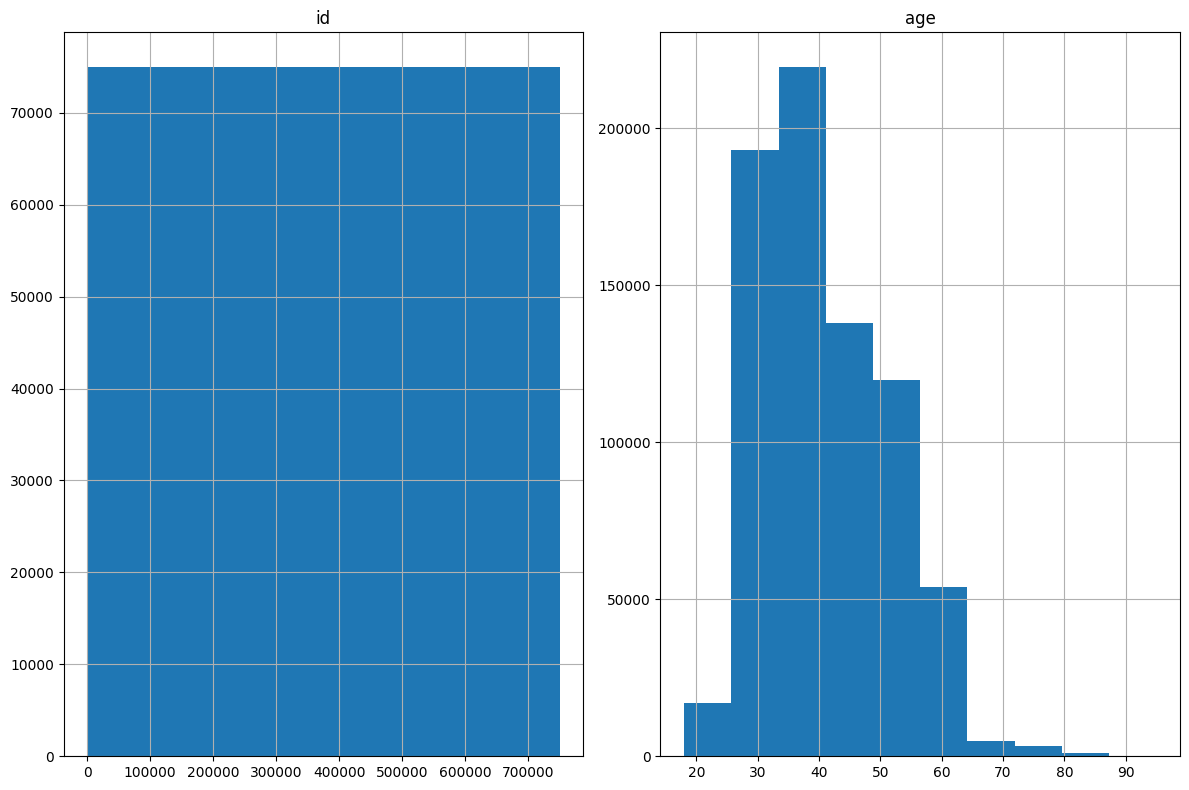

In [2]:
# Load and Explore the Dataset
import os

# Download data if not already present
#if not os.path.exists('train.csv') or not os.path.exists('test.csv'):
#    !kaggle competitions download -c playground-series-s5e8 -p .
#    !unzip -o 'playground-series-s5e8.zip' -d .

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Display basic info
print('Train shape:', train.shape)
print('Test shape:', test.shape)
display(train.head())

# Check for missing values
print('Missing values in train:')
display(train.isnull().sum())

# Visualize key features (example: first 5 columns)
train.iloc[:, :5].hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

## Preprocess the Data
Handle missing values, encode categorical variables, and scale numerical features as needed.

In [3]:
# Preprocess the Data
# Example: fill missing values, encode categoricals, scale numerics
from sklearn.impute import SimpleImputer

# Fill missing values with median for numerics
def preprocess(df):
    df = df.copy()
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    
    imputer = SimpleImputer(strategy='median')
    df[num_cols] = imputer.fit_transform(df[num_cols])
    
    for col in cat_cols:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))
    return df
# Use 'y' as the target column
X = preprocess(train.drop(['y'], axis=1))
y = train['y']
X_test = preprocess(test)

## Feature Engineering
Create new features or transform existing ones to improve model performance.

In [4]:
# Feature Engineering
# Example: create new features or transform existing ones
# (Add your feature engineering code here)
# For now, we proceed with the current features


## Split Data into Training and Validation Sets
Split the training data into training and validation sets to evaluate model performance.

In [5]:
# Split Data into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Training set:', X_train.shape, y_train.shape)
print('Validation set:', X_val.shape, y_val.shape)

Training set: (600000, 17) (600000,)
Validation set: (150000, 17) (150000,)


## Train a Baseline Model
Train a simple machine learning model (e.g., RandomForest, LogisticRegression) on the training data.

In [6]:
# Train a Baseline Model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Evaluate Model Performance
Evaluate the model using appropriate metrics and visualize the results.

Validation Accuracy: 0.9314066666666667
              precision    recall  f1-score   support

           0       0.95      0.97      0.96    131902
           1       0.75      0.64      0.69     18098

    accuracy                           0.93    150000
   macro avg       0.85      0.81      0.83    150000
weighted avg       0.93      0.93      0.93    150000



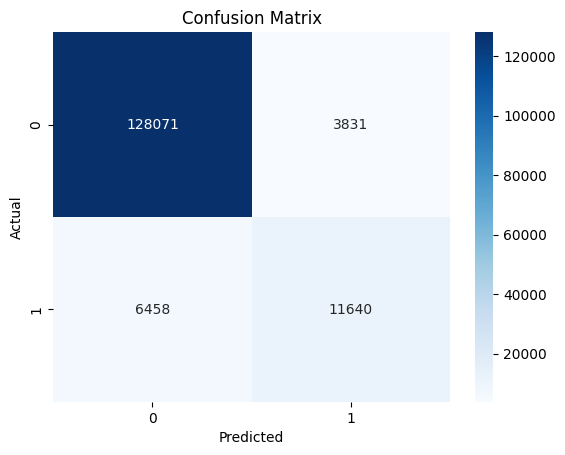

In [7]:
# Evaluate Model Performance
val_preds = rf.predict(X_val)
print('Validation Accuracy:', accuracy_score(y_val, val_preds))
print(classification_report(y_val, val_preds))

# Confusion matrix
cm = confusion_matrix(y_val, val_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Hyperparameter Tuning
Use techniques such as GridSearchCV or RandomizedSearchCV to optimize model hyperparameters.

In [8]:
# Hyperparameter Tuning (faster, avoids timeouts)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Use a subset for tuning to reduce runtime
X_tune = X_train
y_tune = y_train
if len(X_tune) > 150_000:
    X_tune = X_tune.sample(n=150_000, random_state=42)
    y_tune = y_tune.loc[X_tune.index]

# Keep search space compact and avoid extremely deep trees during search
param_distributions = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Parallelize within trees (estimator) and keep CV parallelism single-threaded to avoid oversubscription
base_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
gs = RandomizedSearchCV(
    estimator=base_rf,
    param_distributions=param_distributions,
    n_iter=8,
    cv=3,
    n_jobs=1,
    verbose=1,
    random_state=42
)

# Fit on the (possibly sampled) tuning set
gs.fit(X_tune, y_tune)
print('Best parameters (on sample):', gs.best_params_)
print('Best CV score (on sample):', gs.best_score_)

# Refit best params on full training data with a slightly larger forest
best_params = dict(gs.best_params_)
best_params['n_estimators'] = max(best_params.get('n_estimators', 100), 150)
best_model = RandomForestClassifier(random_state=42, n_jobs=-1, **best_params)
best_model.fit(X_train, y_train)

# For compatibility with later cells
gs.best_estimator_ = best_model


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters (on sample): {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20}
Best CV score (on sample): 0.9293399999999999


## Generate Predictions for Submission
Use the trained model to generate predictions on the test dataset.

In [9]:
# Generate Predictions for Submission
# Use the best estimator from GridSearchCV if available, else use rf
best_model = gs.best_estimator_ if 'gs' in locals() else rf
test_preds = best_model.predict(X_test)


## Create Submission File
Format the predictions according to the competition requirements and save them as a CSV file for submission.

In [10]:
# Create Submission File
# Adjust the column names as per competition requirements
submission = pd.DataFrame({'id': test['id'], 'target': test_preds})
submission.to_csv('submission.csv', index=False)
print('Submission file created: submission.csv')

Submission file created: submission.csv
